# Impact of Threat Type on Lifetime

In [1]:
# Package import
import numpy as np
import pandas as pd 
from datetime import datetime
from datetime import timedelta
from IPython.display import HTML, display
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Color palette
colors = sns.set_palette("rocket")

## General Malware Indicator Dataset

In [2]:
# Remove all rows without a last seen
urlData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_urls.csv',sep=',', skipinitialspace=True)
urlData = urlData.loc[urlData["last_seen_utc"].notna()]

ipData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_ip.csv',sep=',', skipinitialspace=True)
ipData = ipData.loc[ipData["last_seen_utc"].notna()]

hashData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_md5.csv',sep=',', skipinitialspace=True)
hashData = hashData.loc[hashData["last_seen_utc"].notna()]

In [3]:
# Remove all rows where Indicator is younger then one year
present = datetime.now()
past = timedelta(days=31)
year = present - past

urlData["last_seen_utc"] = urlData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData["first_seen_utc"] = urlData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData = urlData[urlData["last_seen_utc"] < year]
urlData = urlData[urlData["last_seen_utc"] != urlData["first_seen_utc"]]

ipData["last_seen_utc"] = ipData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData["first_seen_utc"] = ipData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData = ipData[ipData["last_seen_utc"] < year]
ipData = ipData[ipData["last_seen_utc"] != ipData["first_seen_utc"]]

hashData["last_seen_utc"] = hashData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData["first_seen_utc"] = hashData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData = hashData[hashData["last_seen_utc"] < year]
hashData = hashData[hashData["last_seen_utc"] != hashData["first_seen_utc"]]

In [4]:
# Calculate lifetime and delete negative values
urlData['lifetimeHours'] = (urlData["last_seen_utc"] - urlData["first_seen_utc"]) / pd.Timedelta(hours=1)
urlData = urlData[urlData['lifetimeHours'] >= 0].dropna()

ipData['lifetimeHours'] = (ipData["last_seen_utc"] - ipData["first_seen_utc"]) / pd.Timedelta(hours=1)
ipData = ipData[ipData['lifetimeHours'] >= 0].dropna()

hashData['lifetimeHours'] = (hashData["last_seen_utc"] - hashData["first_seen_utc"]) / pd.Timedelta(hours=1)
hashData = hashData[hashData['lifetimeHours'] >= 0].dropna()

In [5]:
fullData = pd.concat([urlData, hashData, ipData], axis=0)
fullData.shape[0]

127448

### Analysis of the Database

In [6]:
fullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127448 entries, 66 to 152673
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   first_seen_utc     127448 non-null  datetime64[ns]
 1   ioc_id             127448 non-null  float64       
 2   ioc_value          127448 non-null  object        
 3   ioc_type           127448 non-null  object        
 4   threat_type        127448 non-null  object        
 5   fk_malware         127448 non-null  object        
 6   malware_alias      127448 non-null  object        
 7   malware_printable  127448 non-null  object        
 8   last_seen_utc      127448 non-null  datetime64[ns]
 9   confidence_level   127448 non-null  float64       
 10  reference          127448 non-null  object        
 11  tags               127448 non-null  object        
 12  anonymous          127448 non-null  float64       
 13  reporter           127448 non-null  object 

### Threat Type

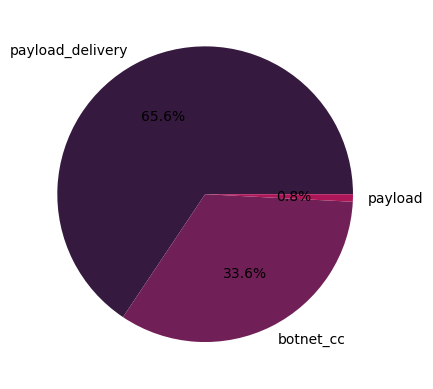

In [7]:
threat_count = fullData["threat_type"].value_counts()
plt.pie(threat_count.values, labels = threat_count.index, colors = colors, autopct='%1.1f%%')
plt.show()

In [8]:
fullData['num_threat_type']=fullData['threat_type'].astype('category').cat.codes
print(fullData["num_threat_type"].corr(fullData["lifetimeHours"]))

-0.4176068537410834


In [9]:
# Display information
average = [["botnet_cc Mean Lifetime",fullData.loc[(fullData['threat_type'] == "botnet_cc"), 'lifetimeHours'].mean()], 
           ["botnet_cc Mode Lifetime",fullData.loc[(fullData['threat_type'] == "botnet_cc"), 'lifetimeHours'].mode()[0]], 
           ["botnet_cc Dataset",fullData.loc[(fullData['threat_type'] == "botnet_cc")].shape[0]], 
           ["payload Mean Lifetime",fullData.loc[(fullData['threat_type'] == "payload"), 'lifetimeHours'].mean()], 
           ["payload Mode Lifetime",fullData.loc[(fullData['threat_type'] == "payload"), 'lifetimeHours'].mode()[0]],
           ["payload Dataset",fullData.loc[(fullData['threat_type'] == "payload")].shape[0]], 
           ["payload_delivery Mean Lifetime",fullData.loc[(fullData['threat_type'] == "payload_delivery"), 'lifetimeHours'].mean()], 
           ["payload_delivery Mode Lifetime",fullData.loc[(fullData['threat_type'] == "payload_delivery"), 'lifetimeHours'].mode()[0]], 
           ["payload_delivery Dataset",fullData.loc[(fullData['threat_type'] == "payload_delivery")].shape[0]]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

botnet_cc Mean Lifetime,3109.479140085776
botnet_cc Mode Lifetime,0.03305555555555555
botnet_cc Dataset,42773
payload Mean Lifetime,79.75546073717949
payload Mode Lifetime,0.002777777777777778
payload Dataset,1040
payload_delivery Mean Lifetime,45.70333631586988
payload_delivery Mode Lifetime,0.006944444444444444
payload_delivery Dataset,83635


In [10]:
# Split1 = 50/50
split1_50_train, split1_50_test = train_test_split(fullData, test_size=0.5)

# Split1 = 70/30
split2_30_train, split2_70_test = train_test_split(fullData, test_size=0.7)

# Split1 = 30/70
split3_70_train, split3_30_test = train_test_split(fullData, test_size=0.3)

In [11]:
# Display information
average = [["split1_50_train Lifetime",split1_50_train["num_threat_type"].corr(split1_50_train["lifetimeHours"])], 
           ["split1_50_test Lifetime",split1_50_test["num_threat_type"].corr(split1_50_test["lifetimeHours"])], 
           ["split2_30_train Lifetime",split2_30_train["num_threat_type"].corr(split2_30_train["lifetimeHours"])],
           ["split2_70_test Lifetime",split2_70_test["num_threat_type"].corr(split2_70_test["lifetimeHours"])], 
           ["split3_70_train Lifetime",split3_70_train["num_threat_type"].corr(split3_70_train["lifetimeHours"])],
            ["split3_30_test Lifetime",split3_30_test["num_threat_type"].corr(split3_30_test["lifetimeHours"])]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

split1_50_train Lifetime,-0.41815655732840423
split1_50_test Lifetime,-0.4170604989551062
split2_30_train Lifetime,-0.4207018449937864
split2_70_test Lifetime,-0.4162758210162464
split3_70_train Lifetime,-0.4176818892354393
split3_30_test Lifetime,-0.41743492921691255


### Malware Familiy

In [12]:
fullData["fk_malware"].value_counts()

win.qakbot             83801
win.cobalt_strike       9216
win.redline_stealer     4808
unknown                 2889
win.emotet              2661
                       ...  
win.sidewinder             1
elf.plead                  1
win.winnti                 1
win.machete                1
win.buer                   1
Name: fk_malware, Length: 242, dtype: int64

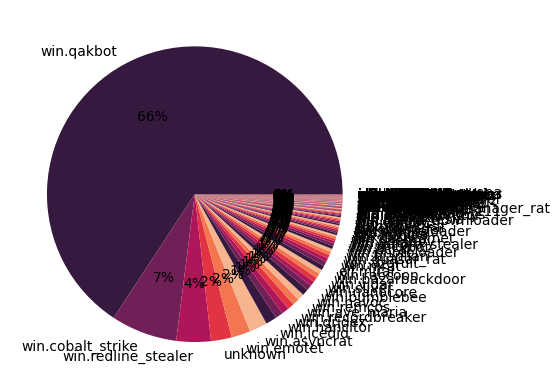

In [13]:
threat_count = fullData["fk_malware"].value_counts()
plt.pie(threat_count.values, labels = threat_count.index, colors = colors, autopct='%.0f%%')
plt.show()

In [14]:
fullData['num_fk_malware']=fullData['fk_malware'].astype('category').cat.codes
print(fullData["num_fk_malware"].corr(fullData["lifetimeHours"]))

-0.1928715034293814


In [15]:
# Display information
average = [["win.qakbot Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.qakbot"), 'lifetimeHours'].mean()], 
           ["win.qakbot Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.qakbot"), 'lifetimeHours'].mode()[0]], 
           ["win.qakbot Dataset",fullData.loc[(fullData['fk_malware'] == "win.qakbot")].shape[0]], 
           ["win.redline_stealer Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.redline_stealer"), 'lifetimeHours'].mean()], 
           ["win.redline_stealer Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.redline_stealer"), 'lifetimeHours'].mode()[0]],
           ["win.redline_stealer Dataset",fullData.loc[(fullData['fk_malware'] == "win.redline_stealer")].shape[0]], 
           ["win.cobalt_strike Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.cobalt_strike"), 'lifetimeHours'].mean()], 
           ["win.cobalt_strike Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.cobalt_strike"), 'lifetimeHours'].mode()[0]], 
           ["win.cobalt_strike Dataset",fullData.loc[(fullData['fk_malware'] == "win.cobalt_strike")].shape[0]],
           ["win.emotet Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.emotet"), 'lifetimeHours'].mean()], 
           ["win.emotet Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.emotet"), 'lifetimeHours'].mode()[0]], 
           ["win.emotet Dataset",fullData.loc[(fullData['fk_malware'] == "win.emotet")].shape[0]], 
           ["win.asyncrat Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.asyncrat"), 'lifetimeHours'].mean()], 
           ["win.asyncrat Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.asyncrat"), 'lifetimeHours'].mode()[0]],
           ["win.asyncrat Dataset",fullData.loc[(fullData['fk_malware'] == "win.asyncrat")].shape[0]], 
           ["win.icedid Mean Lifetime",fullData.loc[(fullData['fk_malware'] == "win.icedid"), 'lifetimeHours'].mean()], 
           ["win.icedid Mode Lifetime",fullData.loc[(fullData['fk_malware'] == "win.icedid"), 'lifetimeHours'].mode()[0]], 
           ["win.icedid Dataset",fullData.loc[(fullData['fk_malware'] == "win.icedid")].shape[0]]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

win.qakbot Mean Lifetime,158.50444379475715
win.qakbot Mode Lifetime,4.521944444444444
win.qakbot Dataset,83801
win.redline_stealer Mean Lifetime,6739.715715012017
win.redline_stealer Mode Lifetime,0.37222222222222223
win.redline_stealer Dataset,4808
win.cobalt_strike Mean Lifetime,1593.0567977792246
win.cobalt_strike Mode Lifetime,0.7802777777777777
win.cobalt_strike Dataset,9216
win.emotet Mean Lifetime,1743.165143534177
win.emotet Mode Lifetime,0.025277777777777777


In [16]:
# Split1 = 50/50
split1_50_train, split1_50_test = train_test_split(fullData, test_size=0.5)

# Split1 = 70/30
split2_30_train, split2_70_test = train_test_split(fullData, test_size=0.7)

# Split1 = 30/70
split3_70_train, split3_30_test = train_test_split(fullData, test_size=0.3)

In [17]:
# Display information
average = [["split1_50_train Lifetime",split1_50_train["num_fk_malware"].corr(split1_50_train["lifetimeHours"])], 
           ["split1_50_test Lifetime",split1_50_test["num_fk_malware"].corr(split1_50_test["lifetimeHours"])], 
           ["split2_30_train Lifetime",split2_30_train["num_fk_malware"].corr(split2_30_train["lifetimeHours"])],
           ["split2_70_test Lifetime",split2_70_test["num_fk_malware"].corr(split2_70_test["lifetimeHours"])], 
           ["split3_70_train Lifetime",split3_70_train["num_fk_malware"].corr(split3_70_train["lifetimeHours"])],
            ["split3_30_test Lifetime",split3_30_test["num_fk_malware"].corr(split3_30_test["lifetimeHours"])]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

split1_50_train Lifetime,-0.18799540891777788
split1_50_test Lifetime,-0.1976484535398026
split2_30_train Lifetime,-0.18923543942763724
split2_70_test Lifetime,-0.19446134240813115
split3_70_train Lifetime,-0.19309943597523022
split3_30_test Lifetime,-0.1923377212044022


## URL APT Phishing Indicator Dataset

In [18]:
customData = pd.read_csv(".\Data\\Phishing\VT_Submissions_Metadata.csv", sep=",", encoding='windows-1252')
# Separat sightings
customData["sightings"] = customData["sightings"].str.split("#")

# Remove all rows where the indicator is younger than 1 month
present = datetime.now()
past = timedelta(days=31)
year = present - past

customData["Last Submission"] = customData["Last Submission"].apply(lambda x: pd.to_datetime(x))
customData["First Submission"] = customData["First Submission"].apply(lambda x: pd.to_datetime(x))
customData["lifetimeInHours"] = (customData["Last Submission"] - customData["First Submission"]) / pd.Timedelta(hours=1)
customData = customData[customData["Last Submission"] < year]
customData = customData[customData["Last Submission"] != customData["First Submission"]]
customData = customData[customData['lifetimeInHours'] >= 0].dropna()
customData = customData[customData['Malicious'] != 0]

In [19]:
customData.head()

,Unnamed: 0,Indicator,ID,Type,Threat Name,TLD,Last Submission,First Submission,Malicious,Harmless,sightings,lifetimeInHours
0,0,calendar-ua.firstcloudit.com,3744f508ffae357561e31e0a57d33336d82f71da7674cb...,url,['Mal/HTMLGen-A'],com,2024-10-06 01:45:00,2024-02-27 06:52:40,6,62,"[2024-10-06 01:45:00, 2024-10-05 23:25:43, 202...",5322.872222
1,0,calendarua.firstcloudit.com,0a8ce89569d558d9fefcb4ab46c3a276fb59716a93cf44...,url,['Mal/HTMLGen-A'],com,2024-10-05 23:26:13,2024-02-27 06:52:44,5,63,"[2024-10-05 23:26:13, 2024-08-30 04:38:24, 202...",5320.558056
2,0,dls-gov.firstcloudit.com,70ea1dc461e51cd37480afb52fd758218bfcedd95f4063...,url,[],com,2024-09-29 16:57:38,2024-02-27 06:52:37,7,62,"[2024-09-29 16:57:38, 2024-08-30 04:38:25, 202...",5170.083611
3,0,e-gov-am.firstcloudit.com,e24501b97c978979be2c26ac0533cffec5eb7151595335...,url,[],com,2024-09-29 16:57:57,2023-11-27 18:12:56,6,61,"[2024-09-29 16:57:57, 2024-08-30 04:38:25, 202...",7366.750278
4,0,e-gov.firstcloudit.com,af5fda8a5f3a352efb4d1dd69c3edc3e740bd59375099b...,url,[],com,2024-09-29 16:57:39,2024-02-27 06:52:43,6,61,"[2024-09-29 16:57:39, 2024-08-30 04:38:25, 202...",5170.082222


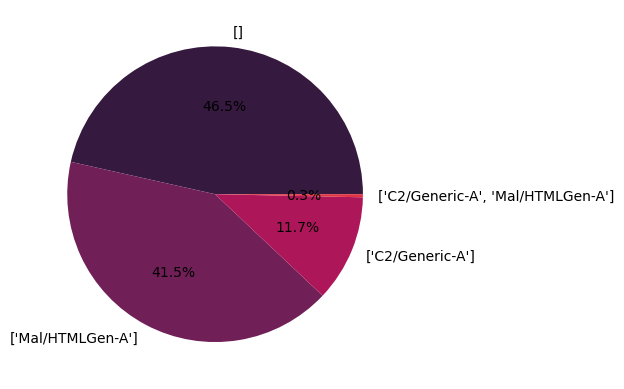

In [20]:
threat_name_count = customData["Threat Name"].value_counts()
plt.pie(threat_name_count.values, labels = threat_name_count.index, colors = colors, autopct='%1.1f%%')
plt.show()

In [21]:
customData = customData[customData["Threat Name"] != "[]"]
customData['num_threat_name']=customData['Threat Name'].astype('category').cat.codes
print(customData["num_threat_name"].corr(customData["lifetimeInHours"]))

-0.46192852647796323


In [22]:
# Split1 = 50/50
split1_50_train_vt, split1_50_test_vt = train_test_split(customData, test_size=0.5)

# Split1 = 70/30
split2_30_train_vt, split2_70_test_vt = train_test_split(customData, test_size=0.7)

# Split1 = 30/70
split3_70_train_vt, split3_30_test_vt = train_test_split(customData, test_size=0.3)

In [23]:
# Display information
average = [["split1_50_train Lifetime",split1_50_train_vt["num_threat_name"].corr(split1_50_train_vt["lifetimeInHours"])], 
           ["split1_50_test Lifetime",split1_50_test_vt["num_threat_name"].corr(split1_50_test_vt["lifetimeInHours"])], 
           ["split2_30_train Lifetime",split2_30_train_vt["num_threat_name"].corr(split2_30_train_vt["lifetimeInHours"])],
           ["split2_70_test Lifetime",split2_70_test_vt["num_threat_name"].corr(split2_70_test_vt["lifetimeInHours"])], 
           ["split3_70_train Lifetime",split3_70_train_vt["num_threat_name"].corr(split3_70_train_vt["lifetimeInHours"])],
            ["split3_30_test Lifetime",split3_30_test_vt["num_threat_name"].corr(split3_30_test_vt["lifetimeInHours"])]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

split1_50_train Lifetime,-0.48727291953296953
split1_50_test Lifetime,-0.44171786770828664
split2_30_train Lifetime,-0.49429240056416696
split2_70_test Lifetime,-0.4511476737827743
split3_70_train Lifetime,-0.46329795660437384
split3_30_test Lifetime,-0.47420974781058245
